# Basic forecasting for COVID-19

Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from JHU CSSE

In [27]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy import optimize
from scipy.stats import norm
from scipy.stats import skewnorm

mpl.rcParams['figure.dpi'] = 120

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
df_raw = pd.read_csv(url)

### Reformat data into convenient form

In [28]:
colnames = df_raw.columns
# aggregate by region
df = df_raw.pivot_table(index='Country/Region',values=colnames[4:],aggfunc=sum)
# make countries columns rather than rows
df = df.T
# make the index a datetime object
df = df.reindex( pd.to_datetime(df.index) )
# sort the dates/times
df.sort_index(inplace=True)
# record the latest date
latest_date = df.index[-1].strftime("%a %b %d, %Y")
print(latest_date)

Fri May 22, 2020


### Helper functions

In [29]:
# define function forms for fitting
def quadratic(x, p0, p1, p2):
    return p0 + p1*x + p2*(x**2)

def cubic(x, p0, p1, p2, p3):
    return p0 + p1*x + p2*(x**2) + p3*(x**3)

def quartic(x, p0, p1, p2, p3, p4):
    return p0 + p1*x + p2*(x**2) + p3*(x**3) + p4*(x**4)

def gaussian(x, k, m, s):
    return k/s * norm.pdf( (x-m)/s )

def skew_gaussian(x, k, m, s, a):
    return k/s * skewnorm.pdf( (x-m)/s, a )

# function that shifts the data so everything starts from first min_deaths
def shift_data( countries, min_deaths ):
    shifted_data = []
    for (c,data) in df[countries].items():
        shifted_data.append( data[data >= min_deaths].reset_index(drop=True) )
    return shifted_data

# fit timeseries data using a functional form
def fit( y, func, date_start, date_end, p0=None ):
    d0 = datetime.date( 2020, 1, 1 )  # this date should be EARLIER than any of the dates we use
    ytrain = y[date_start:date_end]
    ttrain = ytrain.index
    xtrain = np.arange(len(ttrain)) + len(pd.date_range(start=d0,end=date_start))
    p, cov = optimize.curve_fit( func, xdata=xtrain, ydata=ytrain, p0=p0 )
    return p

# forecast timeseries using result from fite model
def forecast( func, date_start, date_end, p):
    d0 = datetime.date( 2020, 1, 1 )  # this date should be EARLIER than any of the dates we use
    ttest = pd.date_range(start=date_start, end=date_end)
    xtest = np.arange(len(ttest)) + len(pd.date_range(start=d0,end=date_start))
    return pd.Series(index=ttest, data=func(xtest, *p))

---

# Why using a "cubic model" is a bad idea

There was some recent news surrounding a "cubic model" that was used to make predictions. Some background:
- First: https://twitter.com/jdawsey1/status/1257395401461727232
- Then this, by Nate Silver: https://twitter.com/NateSilver538/status/1257476755574718470
- and finally this... https://twitter.com/bencasselman/status/1258136404363808769

Cubics (and polynomials in general) are a bad idea to use for modeling for several reasons
- Then tend to perform poorly when _extrapolating_ (predicting beyond the range of your existing data). This is because polynomials all go to either plus or minus infinity as you get farther from your data. Unless you already know this is what your data should be doing, polynomials should not be used for extrapolation.
- Small changes in the model will lead to large changes in predictions. These errors are exacerbated the farther your predicted point is from your original data.
- Since polynomials are unconstrained, they can lead to negative predictions. This is problematic if your data is e.g. the number of deaths, which cannot be a negative number.

These reasons contribute to inconsistent results! We can show this by selecting slightly different date ranges to generate our cubic model. 

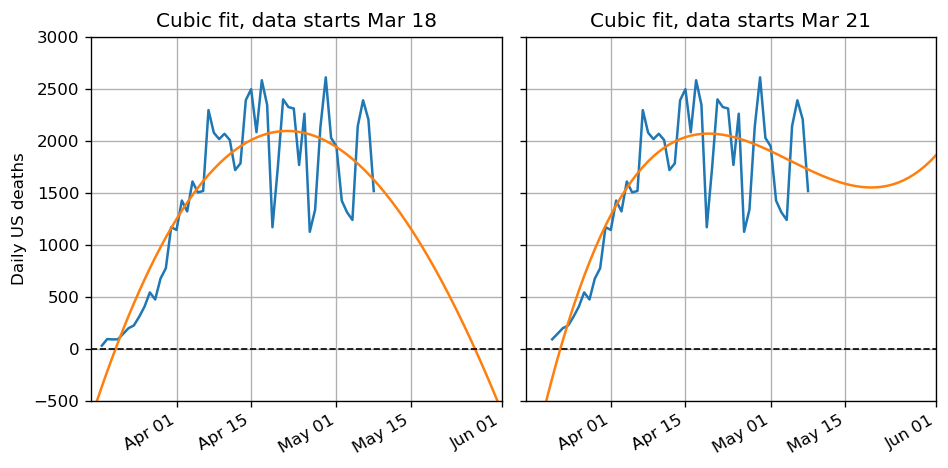

In [30]:
# timeseries data to use (raw data of US daily deaths)
y = df.US.diff().dropna()

# pick two different starting dates and the same end date
fit_start1 = datetime.date(2020, 3, 18)
fit_start2 = datetime.date(2020, 3, 21)
fit_end = datetime.date(2020, 5, 8)

# fit two different cubic models
p1 = fit( y, cubic, fit_start1, fit_end )
p2 = fit( y, cubic, fit_start2, fit_end )

# forecast for both fits
plot_start = datetime.date(2020, 3, 16)
plot_end = datetime.date(2020, 6,1)

y1 = forecast( cubic, plot_start, plot_end, p1 )
y2 = forecast( cubic, plot_start, plot_end, p2 )

# MAKE TWO PLOTS
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,4), sharey=True)
fig.autofmt_xdate()
date_format = "%b %d"

axs[0].plot( y[fit_start1:fit_end] )
axs[0].plot( y1 )
axs[0].set_title("Cubic fit, data starts %s" % fit_start1.strftime(date_format) )
axs[0].set_ylabel("Daily US deaths")

axs[1].plot( y[fit_start2:fit_end] )
axs[1].plot( y2 )
axs[1].set_title("Cubic fit, data starts %s" % fit_start2.strftime(date_format) )

for ax in axs:
    ax.plot( y1*0, 'k--', linewidth=1 )
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.xaxis.set_major_formatter(DateFormatter(date_format))
    ax.grid()

plt.ylim(ymin=-500,ymax=3000)
plt.tight_layout()
plt.savefig("figures/cubic_fit.png")

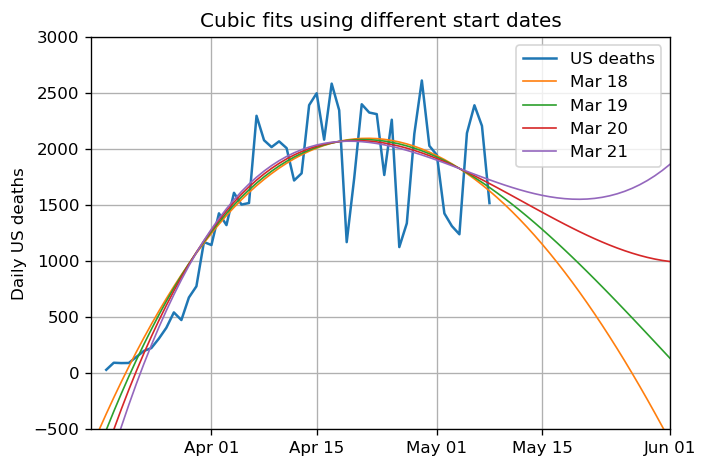

In [31]:
# timeseries data to use (raw data of US daily deaths)
y = df.US.diff().dropna()

# pick two different starting dates and the same end date
fit_starts = pd.date_range( start=datetime.date(2020,3,18), end=datetime.date(2020,3,21) )
fit_end = datetime.date(2020, 5, 8)

# set up the figure
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
# fig.autofmt_xdate()
date_format = "%b %d"

# plot raw data
plt.plot( y[fit_starts[0]:fit_end], label="US deaths" )
plt.title("Cubic fits using different start dates")

# date range to use for forecasting
pred_start = datetime.date(2020, 3, 16)
pred_end   = datetime.date(2020, 6, 1)

# plot forecasts
for fit_start in fit_starts:
    p = fit( y, cubic, fit_start, fit_end )
    ypred = forecast( cubic, pred_start, pred_end, p )
    plt.plot( ypred, linewidth=1, label=fit_start.strftime(date_format) )
    
# format plot
ax.xaxis.set_major_formatter(DateFormatter(date_format))
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Daily US deaths")
plt.ylim(ymin=-500,ymax=3000)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("figures/cubic_fit_multi.png")

### fit cubic to log of data instead

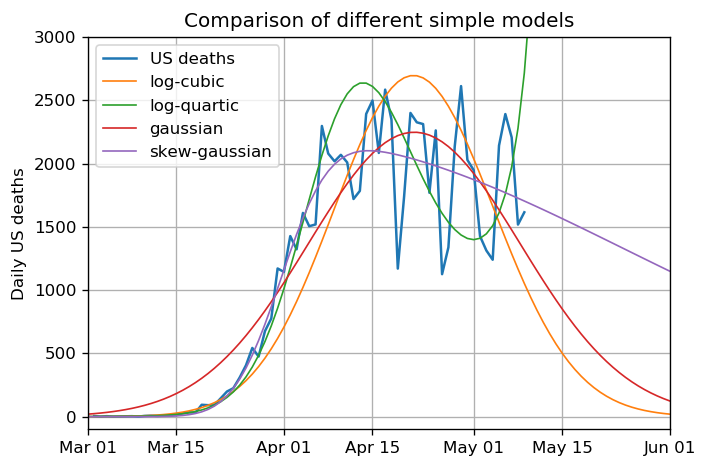

In [32]:
# timeseries data to use (raw data of US daily deaths)
y = df.US.diff().dropna()[39:108]  # first timestamp where data is positive thereafter

# set up the figure
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
# fig.autofmt_xdate()
date_format = "%b %d"

# plot raw data
plt.plot( y, label="US deaths" )

# date range to use for forecasting
pred_start = datetime.date(2020, 3, 1)
pred_end   = datetime.date(2020, 6, 1)

# plot forecasts
p = fit( np.log(y), cubic, y.index[0], y.index[-1] )
ypred = forecast( cubic, pred_start, pred_end, p )
plt.plot( np.exp(ypred), linewidth=1, label="log-cubic" )

# plot forecasts
p = fit( np.log(y), quartic, y.index[0], y.index[-1] )
ypred = forecast( quartic, pred_start, pred_end, p )
plt.plot( np.exp(ypred), linewidth=1, label="log-quartic" )

p = fit( y, gaussian, y.index[0], y.index[-1], p0=[1000,30,10] )
ypred = forecast( gaussian, pred_start, pred_end, p )
plt.plot( ypred, linewidth=1, label="gaussian")

p = fit( y, skew_gaussian, y.index[0], y.index[-1], p0=[1000,30,10,0] )
ypred = forecast( skew_gaussian, pred_start, pred_end, p )
plt.plot( ypred, linewidth=1, label="skew-gaussian")
    
# format plot
ax.xaxis.set_major_formatter(DateFormatter(date_format))
ax.autoscale(enable=True, axis='x', tight=True)
plt.title("Comparison of different simple models")
plt.ylabel("Daily US deaths")
plt.ylim(ymin=-100,ymax=3000)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("figures/more_fits.png")

## skewed normal fit

This uses a [nonlinear least-squares](https://en.wikipedia.org/wiki/Non-linear_least_squares) fit to a [skew-normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution) of the daily number of deaths to account for the fact that the daily deaths seems to rise quickly but drop slowly in most countries. I also smoothed the daily data (using a 7-day moving average) before doing any fitting.

This distribution does a remarkably good job using only 4 parameters:
- mean (the date where the peak occurs)
- scale (the height of the peak)
- standard deviation (the width of the distribution)
- skew factor (how lop-sided the distribution is)

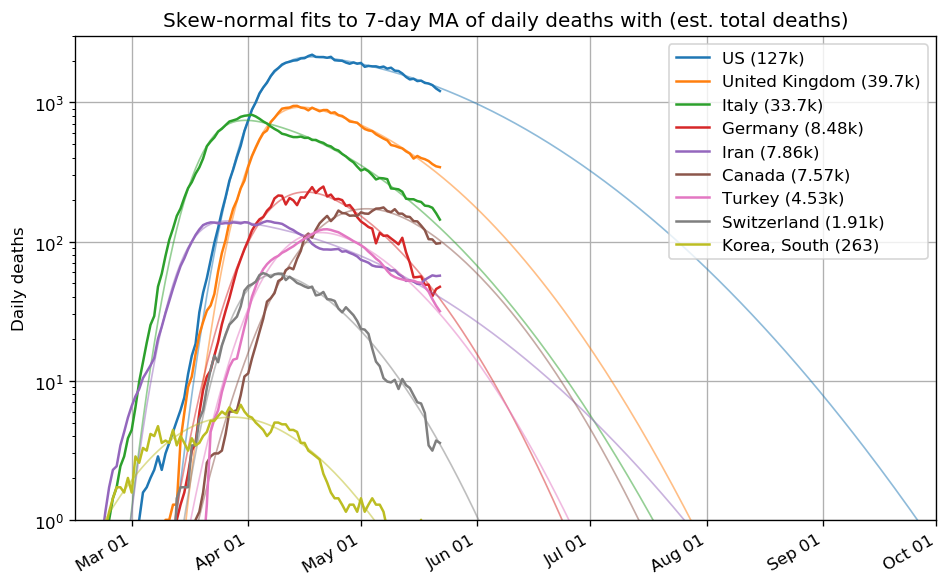

In [33]:
# countries to plot
countries = ['US','United Kingdom','Italy','Germany','Iran','Canada','Turkey','Switzerland','Korea, South']

# timeseries data to use (raw data of US daily deaths)
y = df[countries].diff().rolling(7).mean().dropna()  # first timestamp where data is positive thereafter

# set up the figure
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
fig.autofmt_xdate()
date_format = "%b %d"

# date range to use for forecasting
pred_start = datetime.date(2020, 2, 15)
pred_end   = datetime.date(2020, 10, 1)

for c in countries:
    color = next(ax._get_lines.prop_cycler)['color']
    
    p = fit( y[c], skew_gaussian, y[c].index[0], y[c].index[-1], p0=[max(y[c]),80,20,1] )
    ypred = forecast( skew_gaussian, pred_start, pred_end, p )
    
    # plot raw data and fits
    tot_pred_deaths = sum(ypred)
    if tot_pred_deaths < 1000:
        disp_tot = "%.3g" % tot_pred_deaths
    else:
        disp_tot = "%.3gk" % (tot_pred_deaths/1000)
        
    plt.plot( y[c], color=color, label="%s (%s)" % (c,disp_tot) )    
    plt.plot( ypred, linewidth=1, alpha=0.5, color=color )
    
# format plot
plt.yscale("log")
ax.xaxis.set_major_formatter(DateFormatter(date_format))
ax.autoscale(enable=True, axis='x', tight=True)
plt.title("Skew-normal fits to 7-day MA of daily deaths with (est. total deaths)")
plt.ylabel("Daily deaths")
plt.ylim(ymin=1,ymax=3000)
plt.xlim(xmin=pred_start, xmax=pred_end)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("figures/skew_normal_model_log.png")

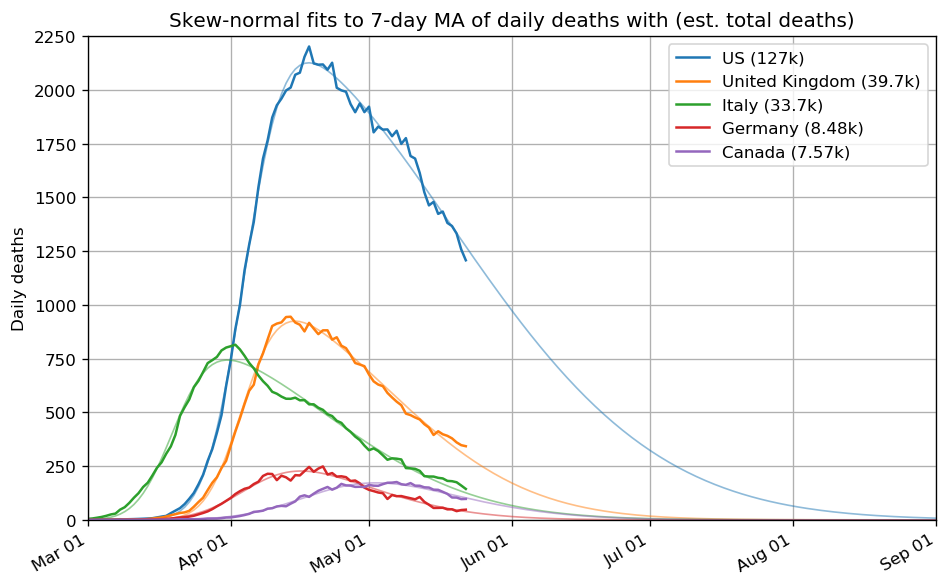

In [34]:
# countries to plot
countries = ['US','United Kingdom','Italy','Germany','Canada']

# timeseries data to use (raw data of US daily deaths)
y = df[countries].diff().rolling(7).mean().dropna()  # first timestamp where data is positive thereafter

# set up the figure
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
fig.autofmt_xdate()
date_format = "%b %d"

# date range to use for forecasting
pred_start = datetime.date(2020, 3, 1)
pred_end   = datetime.date(2020, 9, 1)

for c in countries:
    color = next(ax._get_lines.prop_cycler)['color']
    
    p = fit( y[c], skew_gaussian, y[c].index[0], y[c].index[-1], p0=[max(y[c]),80,20,1] )
    ypred = forecast( skew_gaussian, pred_start, pred_end, p )
#     print("%s  -- (%d,%d,%d,%d)" % (c, *p))
    
    # plot raw data and fits
    tot_pred_deaths = sum(ypred)
    if tot_pred_deaths < 1000:
        disp_tot = "%.3g" % tot_pred_deaths
    else:
        disp_tot = "%.3gk" % (tot_pred_deaths/1000)
        
    plt.plot( y[c], color=color, label="%s (%s)" % (c,disp_tot) )    
    plt.plot( ypred, linewidth=1, alpha=0.5, color=color )
    
# format plot
# plt.yscale("log")
ax.xaxis.set_major_formatter(DateFormatter(date_format))
ax.autoscale(enable=True, axis='x', tight=True)
plt.title("Skew-normal fits to 7-day MA of daily deaths with (est. total deaths)")
plt.ylabel("Daily deaths")
plt.ylim(ymin=0,ymax=2250)
plt.xlim(xmin=pred_start, xmax=pred_end)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("figures/skew_normal_model_linear.png")

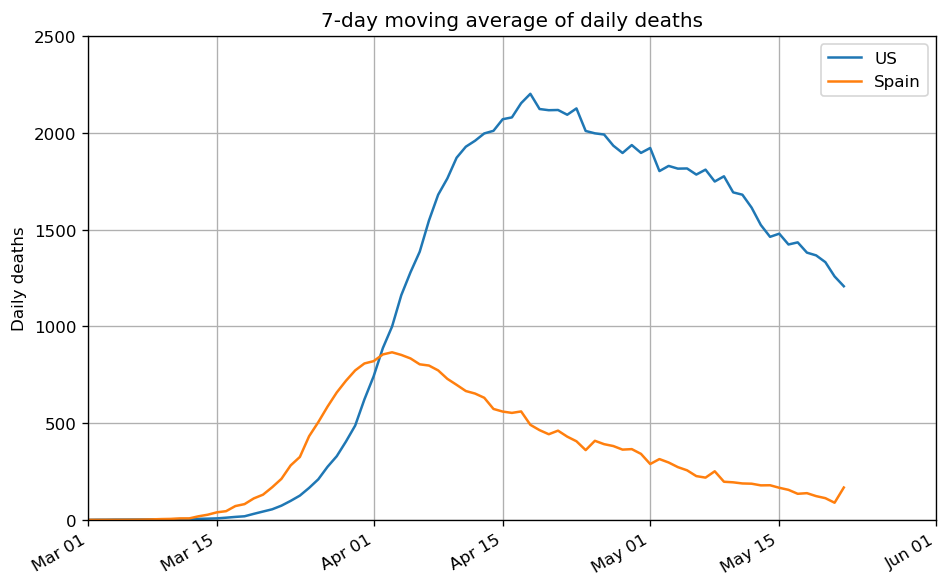

In [35]:
# countries to plot
countries = ['US','Spain']

# timeseries data to use (raw data of US daily deaths)
y = df[countries].diff().rolling(7).mean().dropna()  # first timestamp where data is positive thereafter

# set up the figure
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
fig.autofmt_xdate()
date_format = "%b %d"

# date range to use for forecasting
pred_start = datetime.date(2020, 3, 1)
pred_end   = datetime.date(2020, 6, 1)

for c in countries:
    color = next(ax._get_lines.prop_cycler)['color']
    
    p = fit( y[c], skew_gaussian, y[c].index[0], y[c].index[-1], p0=[max(y[c]),80,20,1] )
    ypred = forecast( skew_gaussian, pred_start, pred_end, p )
#     print("%s  -- (%d,%d,%d,%d)" % (c, *p))
    
    # plot raw data and fits
    tot_pred_deaths = sum(ypred)
    if tot_pred_deaths < 1000:
        disp_tot = "%.3g" % tot_pred_deaths
    else:
        disp_tot = "%.3gk" % (tot_pred_deaths/1000)
        
    plt.plot( y[c], color=color, label=c )    
#     plt.plot( ypred, linewidth=1, alpha=0.5, color=color )
    
# format plot
# plt.yscale("log")
ax.xaxis.set_major_formatter(DateFormatter(date_format))
ax.autoscale(enable=True, axis='x', tight=True)
plt.title("7-day moving average of daily deaths")
plt.ylabel("Daily deaths")
plt.ylim(ymin=0,ymax=2500)
plt.xlim(xmin=pred_start, xmax=pred_end)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("figures/skew_normal_model_linear_simple.png")